In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages
warnings.filterwarnings("ignore")

In [2]:
if not os.path.exists("../images"):
    os.mkdir("../images")

In [3]:
data = pd.read_csv("../data/model_data.csv")
data.head()

,Unnamed: 0,Date,MV Beds Occupied,Hospital Cases,New Admissions,New COVID-19 Cases,New COVID-19 Deaths,New Vaccinations,Vax_index
0,0,2020-04-02,1494.0,12135.0,2932.0,4097.0,892.0,0.0,0.33
1,1,2020-04-03,1788.0,13635.0,2564.0,4102.0,927.0,0.0,0.33
2,2,2020-04-04,1950.0,15469.0,2593.0,3405.0,1023.0,0.0,0.33
3,3,2020-04-05,2097.0,16657.0,2592.0,3094.0,1063.0,0.0,0.33
4,4,2020-04-06,2264.0,17154.0,2679.0,4407.0,1025.0,0.0,0.33


In [4]:
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
columns_drop = [""]

In [5]:
# Function to calculate the Vax index based on the given description and assumptions
def calculate_vax_index(df):
    # Constants for population and vaccination
    total_population = 60_000_000
    number_of_age_groups = 5
    vaccine_efficacy_first_dose = [0.89, 0.427, 0.76, 0.854]
    vaccine_efficacy_second_dose = [0.92, 0.86, 0.81, None]
    age_group_probabilities_icu = [0.01, 0.02, 0.05, 0.1, 0.15]  # Hypothetical ICU need probabilities for different age groups
    monthly_vaccination_rate_increase = 0.05
    # Constants for Vaccination start date
    vaccination_start_date = pd.Timestamp('2021-01-12')
    
    # Divide population into age groups
    population_per_age_group = total_population / number_of_age_groups
    
    # Initialize Vax index list
    vax_index_list = []
    
    # Monthly vaccination rate (starting from 0)
    monthly_vaccination_rate = 0

    # Calculate Vax index for each day
    for index, row in df.iterrows():
        # Initialize Si sum for all age groups
        Si_sum = 0

        # If after vaccination start date, increase monthly vaccination rate
        if row['Date'].day == 1 and row['Date'] > vaccination_start_date:
            monthly_vaccination_rate += monthly_vaccination_rate_increase

        # Calculate Si and Vax index for each age group
        for i in range(number_of_age_groups):
            # Assume vaccination distribution across age groups (aij: two doses, bij: one dose, cij: no doses)
            vaccinated_population = monthly_vaccination_rate * population_per_age_group
            aij = vaccinated_population / 2
            bij = vaccinated_population / 2
            cij = population_per_age_group - aij - bij
            
            # Calculate S''i based on vaccine efficacy and distribution
            S_double_prime_i = sum(wj * aij + vj * (bij - aij) for wj, vj in zip(vaccine_efficacy_second_dose, vaccine_efficacy_first_dose) if wj is not None)

            # Calculate Si
            Si = aij + bij + cij - S_double_prime_i
            
            # Age-specific probability (pi)
            pi = age_group_probabilities_icu[i]
            
            # Sum Si for all age groups
            Si_sum += pi * (aij + bij + cij - S_double_prime_i) / (aij + bij + cij)
        
        # Calculate Vax index for the day
        vax_index = Si_sum
        vax_index_list.append(vax_index)

    # Add Vax index to the dataframe
    df['Vax_index'] = vax_index_list
    return df

In [6]:
# Calculating Vax index for the data
data = calculate_vax_index(data.copy())
data.head()

,Unnamed: 0,Date,MV Beds Occupied,Hospital Cases,New Admissions,New COVID-19 Cases,New COVID-19 Deaths,New Vaccinations,Vax_index
0,0,2020-04-02,1494.0,12135.0,2932.0,4097.0,892.0,0.0,0.33
1,1,2020-04-03,1788.0,13635.0,2564.0,4102.0,927.0,0.0,0.33
2,2,2020-04-04,1950.0,15469.0,2593.0,3405.0,1023.0,0.0,0.33
3,3,2020-04-05,2097.0,16657.0,2592.0,3094.0,1063.0,0.0,0.33
4,4,2020-04-06,2264.0,17154.0,2679.0,4407.0,1025.0,0.0,0.33


'../images/trend_analysis_improved.pdf'

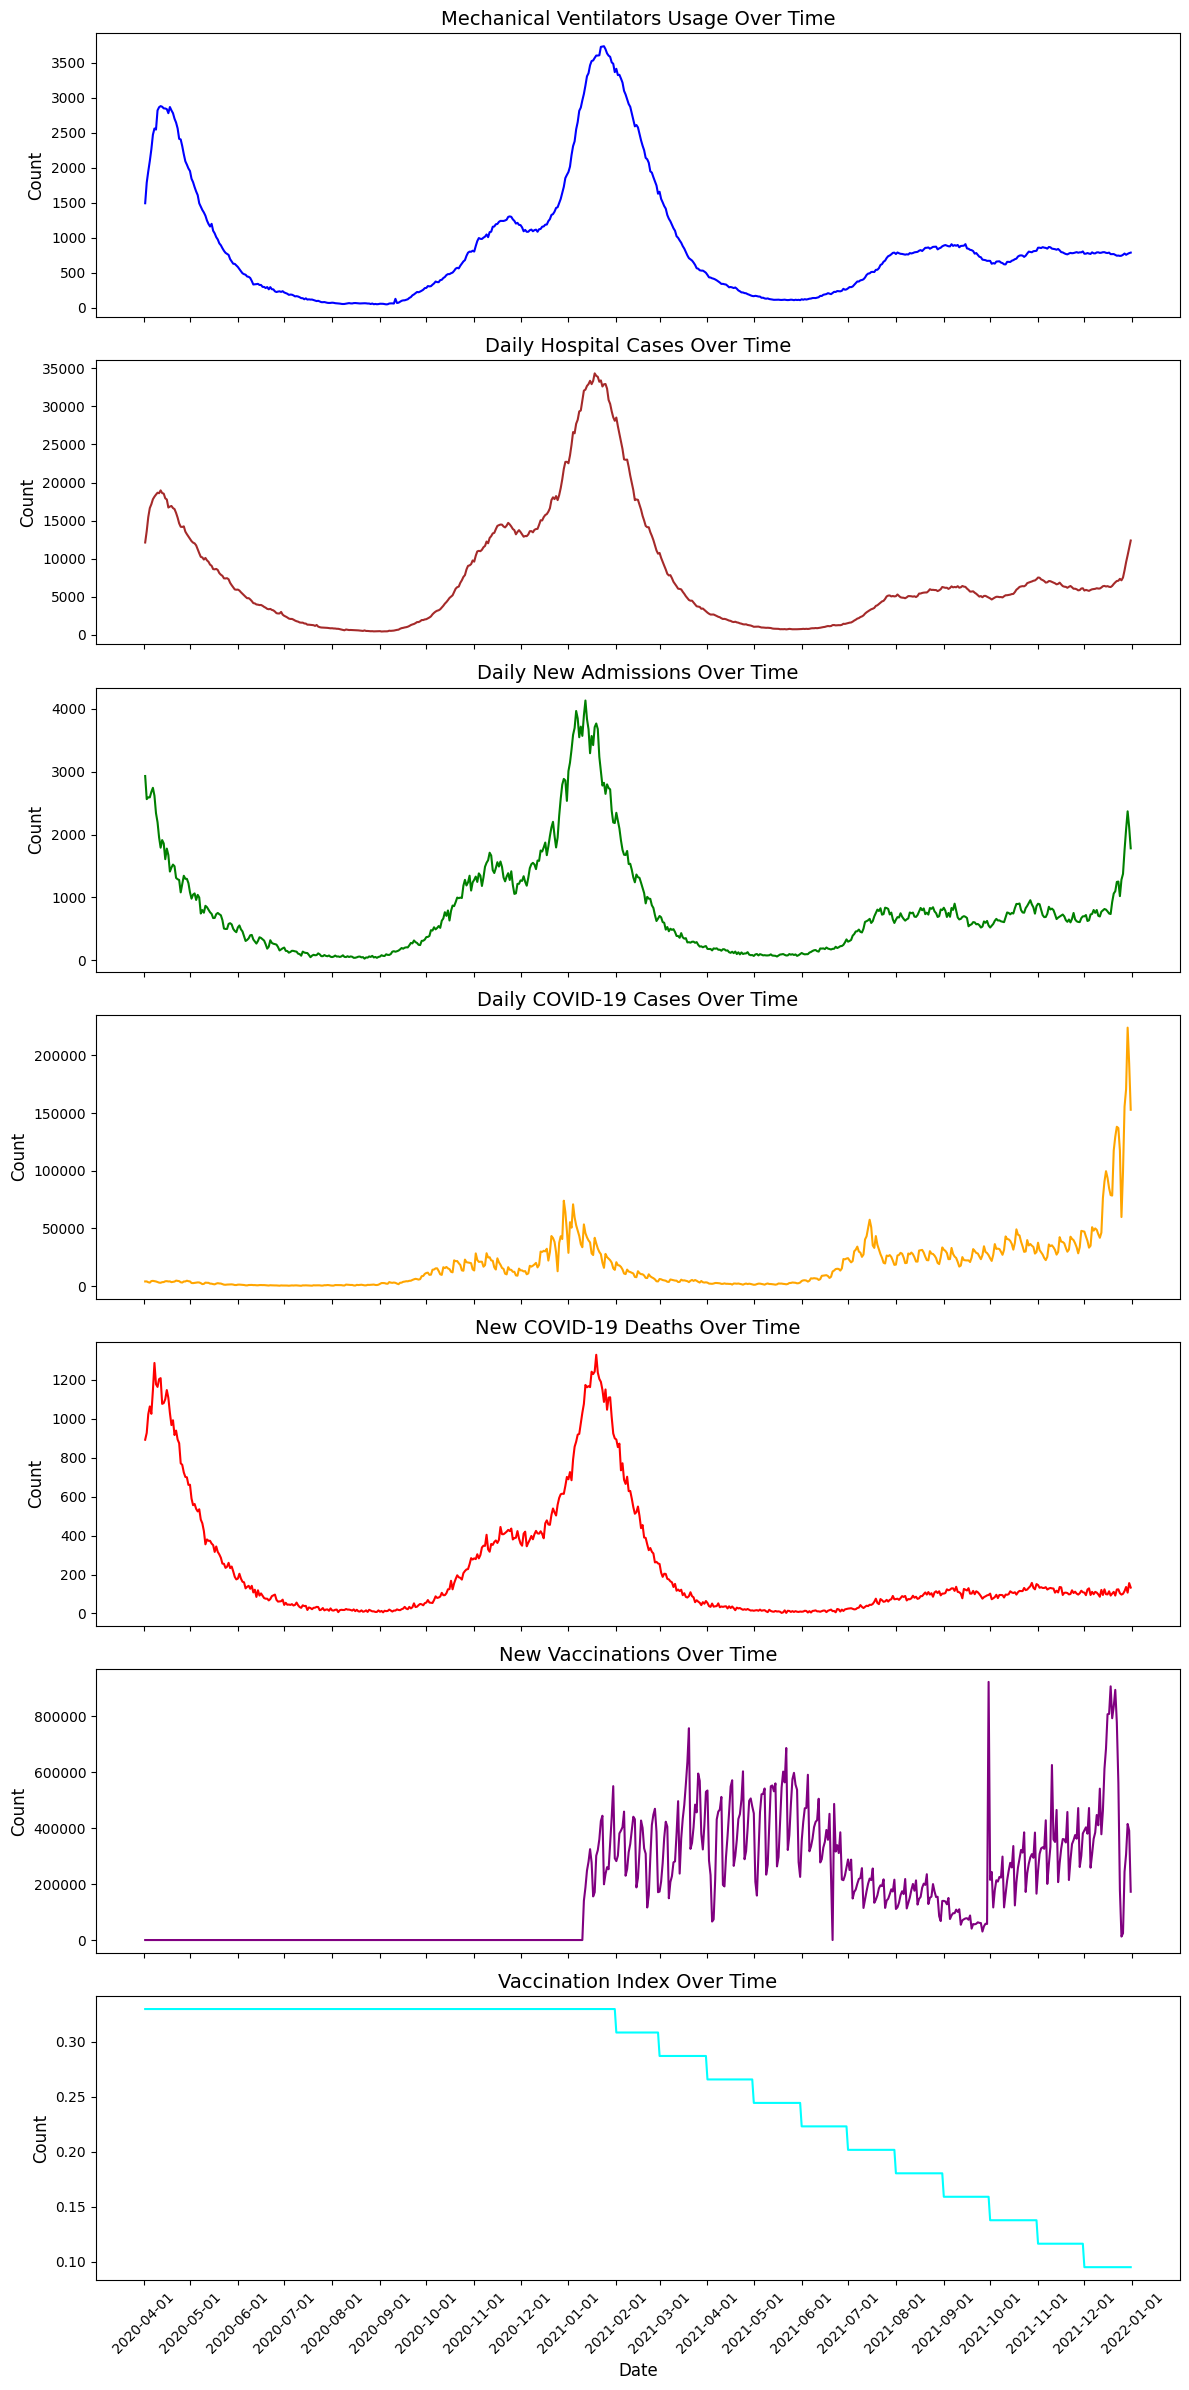

In [7]:
data = data[(data['Date'] >= '2020-01-01') & (data['Date'] <= '2021-12-31')]

# Prepare the figure and subplots with improved readability
fig, axs = plt.subplots(7, 1, figsize=(12, 24), sharex=True)
fig.subplots_adjust(hspace=0.5)

# Define plot details
metrics = ['MV Beds Occupied', 'Hospital Cases', 'New Admissions', 
           'New COVID-19 Cases', 'New COVID-19 Deaths', 'New Vaccinations', 'Vax_index']
colors = ['blue', 'brown', 'green', 'orange', 'red', 'purple', 'cyan']
titles = ['Mechanical Ventilators Usage Over Time', 'Daily Hospital Cases Over Time', 
          'Daily New Admissions Over Time', 'Daily COVID-19 Cases Over Time', 
          'New COVID-19 Deaths Over Time', 'New Vaccinations Over Time', 'Vaccination Index Over Time']

# Plot each metric
for ax, metric, color, title in zip(axs, metrics, colors, titles):
    ax.plot(data['Date'], data[metric], color=color)
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='x', labelrotation=45)
    ax.tick_params(axis='both', labelsize=10)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())

# Set common x-label
axs[-1].set_xlabel('Date', fontsize=12)

# Improve overall layout
plt.tight_layout()

# Save the figure as a PDF
pdf_path_improved = '../images/trend_analysis_improved.pdf'
with PdfPages(pdf_path_improved) as pdf:
    pdf.savefig(fig, bbox_inches='tight')

pdf_path_improved

In [8]:
# # Function to add traces
# def add_trace(fig, x_data, y_data, color, title, row):
#     fig.add_trace(
#         go.Scatter(
#             x=x_data,
#             y=y_data,
#             mode='lines',
#             line=dict(color=color, width=2),
#             name=title,
#             showlegend=True
#         ),
#         row=row, col=1
#     )

# # Create a subplot with 7 rows
# fig_trend = make_subplots(
#     rows=7, cols=1, 
#     shared_xaxes=True, 
#     vertical_spacing=0.03, 
#     subplot_titles=(
#         'Mechanical Ventilators Usage Over Time',
#         'Daily Hospital Cases Over Time', 
#         'Daily New Admissions Over Time',
#         'Daily COVID-19 Cases Over Time',
#         'New COVID-19 Deaths Over Time',
#         "New Vaccinations",
#         "Vaccination Index"
#     )
# )
# # Data for plotting
# data_plot = [
#     (data['Date'], data['MV Beds Occupied'], 'blue', 'Mechanical Ventilators', 1),
#     (data['Date'], data['Hospital Cases'], 'brown', 'Hospital Cases', 2),
#     (data['Date'], data['New Admissions'], 'green', 'New Admissions', 3),
#     (data['Date'], data['New COVID-19 Cases'], 'orange', 'New COVID-19 Cases', 4),
#     (data['Date'], data['New COVID-19 Deaths'], 'red', 'New COVID-19 Deaths', 5),
#     (data["Date"], data["New Vaccinations"], "purple", "New daily vaccination", 6),
#     (data["Date"], data["Vax_index"], "cyan", "vaccination index", 7)
# ]

# # Add data to the subplot
# for item in data_plot:
#     add_trace(fig_trend, *item)

# # Update the layout
# fig_trend.update_layout(
#     height=1500, 
#     width=1000,
#     template="plotly_white",
#     title_text="Trend Analysis for Various COVID-19 Metrics",
#     legend_title_text='Metrics',
#     hovermode="x unified"
# )

# # Update xaxis and yaxis properties
# fig_trend.update_xaxes(title_text="Date", row=7, col=1)
# for i in range(1, 8):
#     fig_trend.update_yaxes(title_text="Count", row=i, col=1)

# fig_trend.show()

# # Save the figure as a PDF
# fig_trend.write_image("trend_analysis.pdf")

In [9]:
# Create a subplot with 7 rows
fig_trend_optimized = make_subplots(
    rows=7, cols=1, 
    shared_xaxes=True, 
    vertical_spacing=0.03, 
    subplot_titles=(
        'Mechanical Ventilators Usage Over Time',
        'Daily Hospital Cases Over Time', 
        'Daily New Admissions Over Time',
        'Daily COVID-19 Cases Over Time',
        'New COVID-19 Deaths Over Time',
        "New Vaccinations",
        "Vaccination Index"
    )
)

# Data for plotting
data_plot_optimized = [
    (data['Date'], data['MV Beds Occupied'], 'blue', 'Mechanical Ventilators', 1),
    (data['Date'], data['Hospital Cases'], 'brown', 'Hospital Cases', 2),
    (data['Date'], data['New Admissions'], 'green', 'New Admissions', 3),
    (data['Date'], data['New COVID-19 Cases'], 'orange', 'New COVID-19 Cases', 4),
    (data['Date'], data['New COVID-19 Deaths'], 'red', 'New COVID-19 Deaths', 5),
    (data['Date'], data['New Vaccinations'], 'purple', 'New Vaccinations', 6),
    (data['Date'], data['Vax_index'], 'cyan', 'Vaccination Index', 7)
]

# Add data to the subplot
for item in data_plot_optimized:
    fig_trend_optimized.add_trace(
        go.Scatter(
            x=item[0],
            y=item[1],
            mode='lines',
            line=dict(color=item[2], width=2),
            name=item[3],
            showlegend=True
        ),
        row=item[4], col=1
    )

# Update the layout
fig_trend_optimized.update_layout(
    height=1500, 
    width=1000,
    template="plotly_white",
    title_text="Trend Analysis for Various COVID-19 Metrics",
    legend_title_text='Metrics',
    hovermode="x unified"
)

# Update xaxis and yaxis properties
fig_trend_optimized.update_xaxes(title_text="Date", row=7, col=1)
for i in range(1, 8):
    fig_trend_optimized.update_yaxes(title_text="Count", row=i, col=1)

# Save the figure as a PDF
pdf_path_plotly = '../images/trend_analysis_plotly.pdf'
fig_trend_optimized.write_image(pdf_path_plotly)

pdf_path_plotly

In [ ]:
data.head()

,Date,MV Beds Occupied,Hospital Cases,New Admissions,New COVID-19 Cases,New COVID-19 Deaths,New Vaccinations,Vax_index
0,2020-04-02,1494.0,12135.0,2932.0,4097.0,892.0,0.0,0.33
1,2020-04-03,1788.0,13635.0,2564.0,4102.0,927.0,0.0,0.33
2,2020-04-04,1950.0,15469.0,2593.0,3405.0,1023.0,0.0,0.33
3,2020-04-05,2097.0,16657.0,2592.0,3094.0,1063.0,0.0,0.33
4,2020-04-06,2264.0,17154.0,2679.0,4407.0,1025.0,0.0,0.33


In [ ]:
data.to_csv("../data/model_data.csv")

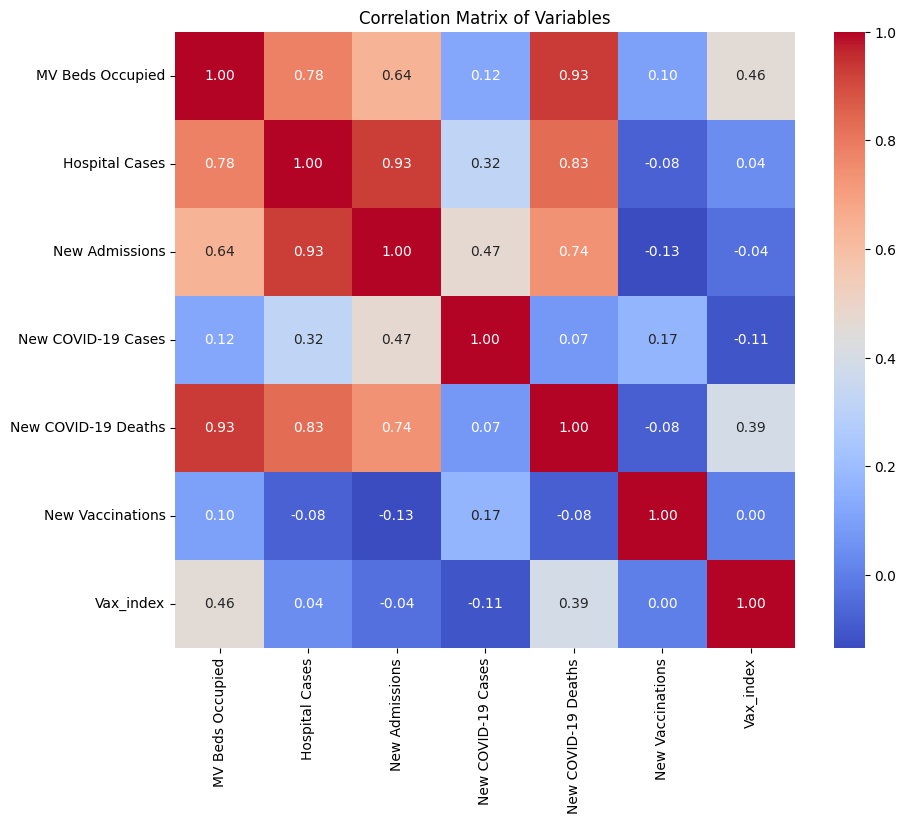

In [ ]:
# Correlation analysis
correlation_matrix = data.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Variables')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

features = data[['MV Beds Occupied', 'Hospital Cases', 'New COVID-19 Cases', 'New Admissions', 'New COVID-19 Deaths', 'New Vaccinations', 'Vax_index']]  # Add other relevant features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


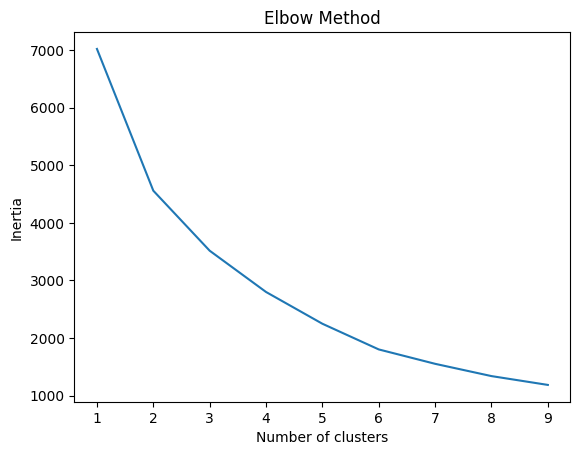

In [ ]:
from sklearn.cluster import KMeans

# Elbow method to find the optimal number of clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the elbow graph
plt.plot(range(1, 10), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


In [ ]:
# Apply K-Means with the chosen number of clusters
optimal_k = 2  # Replace with the chosen k
kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(features_scaled)

# Assign the clusters to the original data
data['Cluster'] = kmeans.labels_


In [ ]:
for i in range(optimal_k):
    cluster = data[data['Cluster'] == i]
    print(f"Cluster {i}:")
    cluster.describe()


Cluster 0:
Cluster 1:


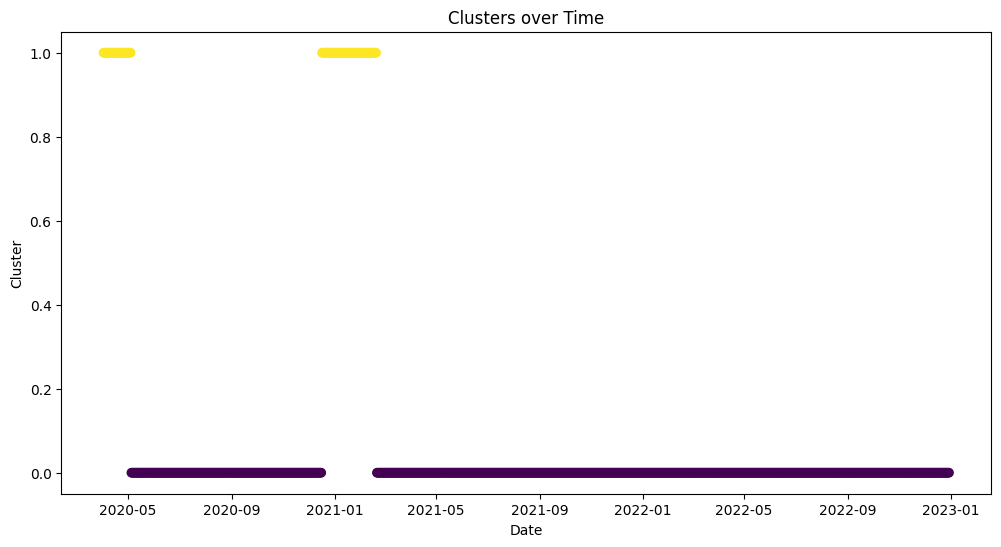

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(data['Date'], data['Cluster'], c=data['Cluster'])
plt.title('Clusters over Time')
plt.xlabel('Date')
plt.ylabel('Cluster')
plt.show()


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming 'data' is your DataFrame and 'MV Beds Occupied' is the target variable
# Convert the DataFrame to a PyTorch Tensor
data_tensor = torch.tensor(data, dtype=torch.float32)

# Define a function to create sequences
def create_sequences(input_data, target_column, sequence_length):
    sequences = []
    target_size = len(input_data) - sequence_length
    for i in range(target_size):
        sequence = input_data[i:i+sequence_length]
        target = input_data[i+sequence_length][target_column]
        sequences.append((sequence, target))
    return sequences

# Create sequences
sequence_length = 5  # This is a hyperparameter you can tune
target_column = data.columns.get_loc("MV Beds Occupied")
sequences = create_sequences(data_tensor, target_column, sequence_length)

# Split data into training and testing sets
train_size = int(0.8 * len(sequences))
train_sequences, test_sequences = sequences[:train_size], sequences[train_size:]

# Create DataLoaders
train_loader = DataLoader(train_sequences, batch_size=64, shuffle=True)
test_loader = DataLoader(test_sequences, batch_size=64, shuffle=False)


ValueError: could not determine the shape of object type 'DataFrame'